In [1]:
import glob
import os
import subprocess
import datetime as dt
from pathlib import Path

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mintpy import view, plot_network
from mintpy.objects import gnss, timeseries, ifgramStack
from mintpy.smallbaselineApp import TimeSeriesAnalysis
from mintpy.utils import ptime, readfile, utils as ut
from scipy import signal

from urllib.request import urlretrieve
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
InSAR_ts_filename1 = r'C:\Users\bvarugu\Documents\Concord\Asc\corrected_ts.h5';
insar_ts1, insar_metadata1 = readfile.read(InSAR_ts_filename1)
(S1,N1,W1,E1) = ut.four_corners(insar_metadata1)
start_date1 = insar_metadata1.get('START_DATE', None)
end_date1 = insar_metadata1.get('END_DATE', None)

In [3]:
InSAR_ts_filename2 = r'C:\Users\bvarugu\Documents\Lamont_Earthquake\ARIA_products\Asc\corrected_ts.h5';
insar_ts2, insar_metadata2 = readfile.read(InSAR_ts_filename2)
(S1,N1,W1,E1) = ut.four_corners(insar_metadata2)
start_date2 = insar_metadata2.get('START_DATE', None)
end_date2 = insar_metadata2.get('END_DATE', None)

In [4]:
from mintpy.asc_desc2horz_vert import get_overlap_lalo
(S,N,W,E) = get_overlap_lalo([insar_metadata1,insar_metadata2]);

start_date = str(min(int(start_date1),int(start_date2)));
end_date = str(max(int(end_date1),int(end_date2)));
print(S,N,W,E)
print(start_date,end_date)

35.580819101 36.24165217 -121.390784777 -118.501619266
20220319 20240916


In [9]:
gnss_source = 'ESESES';
site_names, site_lats, site_lons = gnss.search_gnss(SNWE=(S,N,W,E), source=gnss_source,start_date=start_date, end_date=end_date);
site_names = [str(stn) for stn in site_names]

mask1 = readfile.read(os.path.join(os.path.dirname(InSAR_ts_filename1),'maskTempCoh.h5'))[0]
azimuthAngle1 = readfile.read(os.path.join(os.path.dirname(InSAR_ts_filename1),'geometryGeo.h5'),datasetName='azimuthAngle')[0];
incidenceAngle1 = readfile.read(os.path.join(os.path.dirname(InSAR_ts_filename1),'geometryGeo.h5'),datasetName='incidenceAngle')[0];
site_y1,site_x1 = ut.coordinate(insar_metadata1).geo2radar(site_lats, site_lons)[0:2];
site_azimuthAngles1 = [azimuthAngle1[row,col] for row, col in zip(site_y1,site_x1)];
site_incidenceAngles1 = [incidenceAngle1[row,col] for row, col in zip(site_y1,site_x1)];

mask2 = readfile.read(os.path.join(os.path.dirname(InSAR_ts_filename2),'maskTempCoh.h5'))[0]
azimuthAngle2 = readfile.read(os.path.join(os.path.dirname(InSAR_ts_filename2),'geometryGeo.h5'),datasetName='azimuthAngle')[0];
incidenceAngle2 = readfile.read(os.path.join(os.path.dirname(InSAR_ts_filename2),'geometryGeo.h5'),datasetName='incidenceAngle')[0];
site_y2,site_x2 = ut.coordinate(insar_metadata2).geo2radar(site_lats, site_lons)[0:2];
site_azimuthAngles2 = [azimuthAngle2[row,col] for row, col in zip(site_y2,site_x2)];
site_incidenceAngles2 = [incidenceAngle2[row,col] for row, col in zip(site_y2,site_x2)];

load 3655 GNSS sites with fields: site lon lat
keep sites within SNWE of (35.580819101, 36.24165217, -121.390784777, -118.501619266): [72]
['CAND' 'CARH' 'CARR' 'CRBT' 'CRCN' 'DLNO' 'DREW' 'HOGS' 'HUNT' 'JLN5'
 'LAND' 'LOWS' 'MASW' 'MEE1' 'MEE2' 'MIDA' 'MNMC' 'P056' 'P173' 'P278'
 'P279' 'P281' 'P282' 'P283' 'P284' 'P287' 'P288' 'P289' 'P290' 'P291'
 'P292' 'P293' 'P294' 'P295' 'P296' 'P297' 'P298' 'P526' 'P527' 'P530'
 'P531' 'P532' 'P533' 'P539' 'P540' 'P541' 'P542' 'P544' 'P546' 'P547'
 'P552' 'P564' 'P565' 'P571' 'P576' 'P578' 'P602' 'P782' 'P789' 'P790'
 'P809' 'P810' 'PBHR' 'PEA1' 'PEA2' 'PKDB' 'POMM' 'QCY2' 'RNCH' 'SHN5'
 'TBLP' 'WASG']


In [11]:
gps_dir = r'C:\Users\bvarugu\Documents\Concord\GNSS_ESESES'; #os.path.join(os.path.dirname(InSAR_ts_filename),'GNSS_ESESES');
gps_plot_dir = os.path.join(gps_dir,'GNSS_plot');
os.makedirs(gps_plot_dir,exist_ok=True)

In [13]:
def standardize_longitude(lon, limit='-180to180'):
    """Normalize the longitude value range into (-180, 180] or [0, 360).

    Parameters: lon   - float / np.ndarray, longitude in degree
                limit - str, -180to180 or 0to360
    Returns:    lon   - float / np.ndarray, longitude in degree
    """
    lon = np.asarray(lon)

    # ensure data within (-180, 360)
    lon = np.where(lon >= 360, lon - 360, lon)
    lon = np.where(lon <= -180, lon + 360, lon)

    # range option 1: ensure data within (-180, 180]
    if limit == '-180to180':
        lon = np.where(lon > 180, lon - 360, lon)

    # range option 2: ensure data within [0, 360)
    elif limit == '0to360' and np.nanmin(lon) < 0:
        lon = np.where(lon < 0, lon + 360, lon)

    return float(lon) if np.isscalar(lon) else lon
    
class GNSS_ESESES:
    """GNSS child class for daily solutions processed for the Enhanced Solid
    Earth Science ESDR System (ESESES) project by JPL and SOPAC.

    Website: https://cddis.nasa.gov/Data_and_Derived_Products/GNSS/ESESES_products.html
             http://garner.ucsd.edu/pub/measuresESESES_products/
    """
    def __init__(self, site: str, data_dir=None, version='IGS14', url_prefix=None):
        self.site = site
        self.data_dir = data_dir or os.getcwd()  # Default to current working directory
        self.version = version
        self.source = 'ESESES'
        self.url_prefix = url_prefix
        

        # get file
        self.file = os.path.join(self.data_dir, f'{self.site.lower():s}CleanTrend.neu.Z')

        # get url
        # moved to GNSS_ESESES.dload_site() to avoid searching url_prefix
        # when downloading is not needed.


    def dload_site(self, overwrite=True, total_tries=5, print_msg=True):
        """Download GNSS data file.
        """
        from zipfile import ZipFile

        # get url
        if not self.url_prefix:
            self.url_prefix = gnss.get_ESESES_url_prefix()
        self.url = os.path.join(self.url_prefix, os.path.basename(self.file)).replace("\\", "/");#print('URL is',self.url);
        if self.url and overwrite or not os.path.isfile(self.file):
            print(f"downloading site {self.site:s} from {self.source} to {self.file:s}")
            # retry on download fail
            # https://stackoverflow.com/questions/31529151
            remain_tries = total_tries
            while remain_tries > 0 :
                try:
                    urlretrieve(self.url, self.file)
                    print(f'successfully downloaded: {self.url}')
                except:
                    print(f'error downloading {self.url} on trial no. {total_tries-remain_tries}')
                    remain_tries -= 1
                    continue
                else:
                    break

        # call parent class to download
        #super().dload_site(overwrite=overwrite, print_msg=print_msg)

        # uncompress the downloaded *.z file [for ESESES only]
        with ZipFile(self.file, 'r') as fz:
            fz.extractall(self.data_dir)
        self.file = self.file.strip('.Z')    # update file name
        if print_msg:
            print(f'... extracted to {self.file:s}')

        return self.file


    def get_site_lat_lon(self, print_msg=False) -> (float, float):
        """Get station lat/lon based on processing source.
        Retrieve data from the displacement file.

        Modifies:   self.lat/lon - float
        Returns:    self.lat/lon - float
        """
        # download file if it does not exist
        if not os.path.isfile(self.file):
            self.dload_site(print_msg=print_msg)

        # use the uncompressed data file
        if self.file.endswith('.Z'):
            self.file = self.file[:-2]

        with open(self.file) as f:
            lines = f.readlines()

            # latitude
            lat_line = [x for x in lines if x.startswith('# Latitude')][0].strip('\n')
            self.site_lat = float(lat_line.split()[-1])

            # longitude
            lon_line = [x for x in lines if x.startswith('# East Longitude')][0].strip('\n')
            self.site_lon = float(lon_line.split()[-1])

        # ensure longitude in the range of (-180, 180]
        self.site_lon = standardize_longitude(self.site_lon, limit='-180to180')

        return self.site_lat, self.site_lon
    def _crop_to_date_range(self, start_date: str, end_date: str):
        """Crop the time-series given the start/end_date in format YYYYMMDD,
        and create date_list from dates.
        """
        flag = np.ones(len(self.dates), dtype=bool)
        if start_date:
            t0 = ptime.date_list2vector([start_date])[0][0]
            flag[self.dates < t0] = 0
        if end_date:
            t1 = ptime.date_list2vector([end_date])[0][0]
            flag[self.dates > t1] = 0

        self.dates = self.dates[flag]
        self.dis_e = self.dis_e[flag]
        self.dis_n = self.dis_n[flag]
        self.dis_u = self.dis_u[flag]
        self.std_e = self.std_e[flag]
        self.std_n = self.std_n[flag]
        self.std_u = self.std_u[flag]

        # create member var: date_list
        self.date_list = [x.strftime('%Y%m%d') for x in self.dates]


    def read_displacement(self, start_date=None, end_date=None, print_msg=True, display=False):
        """Read GNSS displacement time-series (defined by start/end_date).

        Parameters: start/end_date - str, date in YYYYMMDD format
        Returns:    dates          - 1D np.ndarray of datetime.datetime object
                    dis_e/n/u      - 1D np.ndarray of displacement in meters in float32
                    std_e/n/u      - 1D np.ndarray of displacement STD in meters in float32
        """
        vprint = print if print_msg else lambda *args, **kwargs: None

        # download file if it does not exist
        if not os.path.isfile(self.file):
            self.dload_site(print_msg=print_msg)

        # use the uncompressed data file
        if self.file.endswith('.Z'):
            self.file = self.file[:-2]

        # read data file
        # use the first 9 cols only, as some epoches miss 10-13 cols: CorrNE/NU/EU, Chi-Squared
        #print('reading time and displacement in east/north/vertical direction')
        fc = np.loadtxt(self.file, usecols=tuple(range(0,9)))
        num_solution = fc.shape[0]

        # parse dates
        dates = [dt.datetime(int(fc[i, 1]), 1, 1) + dt.timedelta(days=int(fc[i, 2]))
                 for i in range(num_solution)]
        self.dates = np.array(dates)

        # parse displacement data
        (self.dis_n,
         self.dis_e,
         self.dis_u,
         self.std_n,
         self.std_e,
         self.std_u) = fc[:, 3:9].astype(np.float32).T / 1000

        # cut out the specified time range
        self._crop_to_date_range(start_date, end_date)

        # display if requested
        if display:
            self.plot()

        return (self.dates,
                self.dis_e, self.dis_n, self.dis_u,
                self.std_e, self.std_n, self.std_u)

In [55]:
def get_gnss_dis(site_name,gps_dir,start_date,end_date,inc_angle,azm_angle):
    gnss_obj = GNSS_ESESES(site =site_name,data_dir=gps_dir);gnss_obj.get_site_lat_lon();gnss_obj.read_displacement();
    gnss_obj._crop_to_date_range(start_date= start_date, end_date= end_date);
    gnss_obj_dis_los = ut.enu2los(gnss_obj.dis_e,gnss_obj.dis_n, gnss_obj.dis_u, inc_angle, azm_angle);
    gnss_lalo = (gnss_obj.site_lat, gnss_obj.site_lon)

    # get relative LOS displacement on common dates
    #gnss_dates = np.array(sorted(list(set(gnss_obj.dates) & set(ref_gnss_obj.dates))))
    gnss_dates = gnss_obj.dates
    gnss_dis = gnss_obj_dis_los#np.zeros(gnss_dates.shape, dtype=np.float32)
    gnss_dis -= np.nanmedian(gnss_dis[0:5])
    return gnss_dates,gnss_dis

wind=2;


# print(f'reading timeseries from file: {insar_ts_file}')
output_pdf_file = r'C:\Users\bvarugu\Documents\compare_overlap_area_ts.pdf';
# # Get date list
date_list1 = timeseries(InSAR_ts_filename1).get_date_list()
date_list2 = timeseries(InSAR_ts_filename2).get_date_list()
insar_dates1 = ptime.date_list2vector(date_list1)[0];
insar_dates2 = ptime.date_list2vector(date_list2)[0];

num_site = len(site_names)
prog_bar = ptime.progressBar(maxValue=num_site)
with PdfPages(output_pdf_file) as pdf:
    fig_count = 0  # To keep track of how many figures are plotted on a page
    fig, axs = plt.subplots(4, 1, figsize=(8, 12), sharex=True)  # Create a 4x1 grid of subplots (4 figures per page)
    for i, site_name in enumerate(site_names):
        prog_bar.update(i+1, suffix=f'{site_name} {i+1}/{num_site}');

        gnss_dates1,gnss_dis1 = get_gnss_dis(site_name,gps_dir,start_date,end_date,site_incidenceAngles1[i],site_azimuthAngles1[i]);
        gnss_dates2,gnss_dis2 = get_gnss_dis(site_name,gps_dir,start_date,end_date,site_incidenceAngles2[i],site_azimuthAngles2[i])
    
        # read InSAR
        y1, x1 = site_y1[i],site_x1[i];
        y2, x2 = site_y2[i],site_x2[i];
        #insar_dis = insar_ts[:, y, x] - ref_insar_dis;
        insar_ts1_dis = np.nanmean(insar_ts1[:, y1-wind:y1+wind, x1-wind:x1+wind],axis=(1,2)) #- ref_insar_dis;
        insar_ts2_dis = np.nanmean(insar_ts2[:, y2-wind:y2+wind, x2-wind:x2+wind],axis=(1,2)) 
        
        if gnss_dis1.size > 0 and mask1[y1,x1] !=0 and mask2[y2,x2] !=0:
            ax = axs[fig_count % 4]  # Access the current subplot in the 4x1 grid
            #save_fig_name = os.path.join(gps_plot_dir,'GNSS_{}_vs_INSAR_LOS.png'.format(site_name));
            ax.scatter(gnss_dates1, gnss_dis1*1000, s=2**2, label="GNSS1", color='black');
            ax.scatter(gnss_dates2, gnss_dis2*1000, s=2**2, label="GNSS1", color='grey')
            ax.scatter(insar_dates1, insar_ts1_dis*1000, label="TS1+GNSS", s=25, color='red',alpha=0.5);
            ax.scatter(insar_dates2, insar_ts2_dis*1000, label="TS2+GNSS", s=25, color='orange',alpha=0.5);
            #ax.scatter(insar_dates, ifg_gnss_dis*1000, label="IFG+GNSS", s=25, color='orange',alpha=0.5);
            #ax.scatter(insar_dates, ifg_gnss_corr_dis*1000, label="IFG+GNSS+Corr", s=25, color='red',alpha=0.5);
            # axis format
            ax.set_title(f"Station Name: {site_name}") 
            ax.set_ylabel('LOS displacement [mm]');
            ylim = int(np.ceil((max(abs(insar_ts1_dis))*1000)/100))*100;
            ax.set_ylim([-ylim,ylim]);
            ax.legend();
             # Slant x-axis labels to 45 degrees
            #plt.setp(ax.get_xticklabels(), rotation=45, ha="right")  
            fig_count += 1

            # Save to PDF every 4 plots and reset figure
            if fig_count % 4 == 0:
                pdf.savefig(fig)  # Save current page to PDF
                plt.close(fig)    # Close the figure to free memory
                fig_count = 0
                fig, axs = plt.subplots(4, 1, figsize=(8, 12), sharex=True)  # Create new 4x1 figure for next 4 plots
    if fig_count > 0:
        pdf.savefig(fig)
        plt.close(fig)
prog_bar.close()
#plt.show()

[===>                     8%                       ] DLNO 6/72    0s /     4s

C:\Users\bvarugu\AppData\Local\anaconda3\envs\mintpy\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\bvarugu\AppData\Local\Temp\ipykernel_14196\3502774934.py:11: RuntimeWarning: All-NaN slice encountered
  gnss_dis -= np.nanmedian(gnss_dis[0:5])


[==================================================] WASG 72/72    7s /     0s 


In [19]:
InSAR_tcoh_filename1 = r'C:\Users\bvarugu\Documents\Concord\Asc\inputs\temporalCoherence.h5';
temp_coh1, temp_coh_atr1 = readfile.read(InSAR_tcoh_filename1);

Compare timeseries data on random points in the overlap area

In [32]:
sample_points_file = r'C:\Users\bvarugu\Documents\ArcGIS\Projects\InSAR_discussion\Outputs\Lamont_Concord_Overlap_area_sample_points.csv';
sample_points = pd.read_csv(sample_points_file,header=0);
sample_points_lons = np.array(sample_points['Lon']);
sample_points_lats = np.array(sample_points['Lat']);

[==================================================] 17/17    0s /     0s 


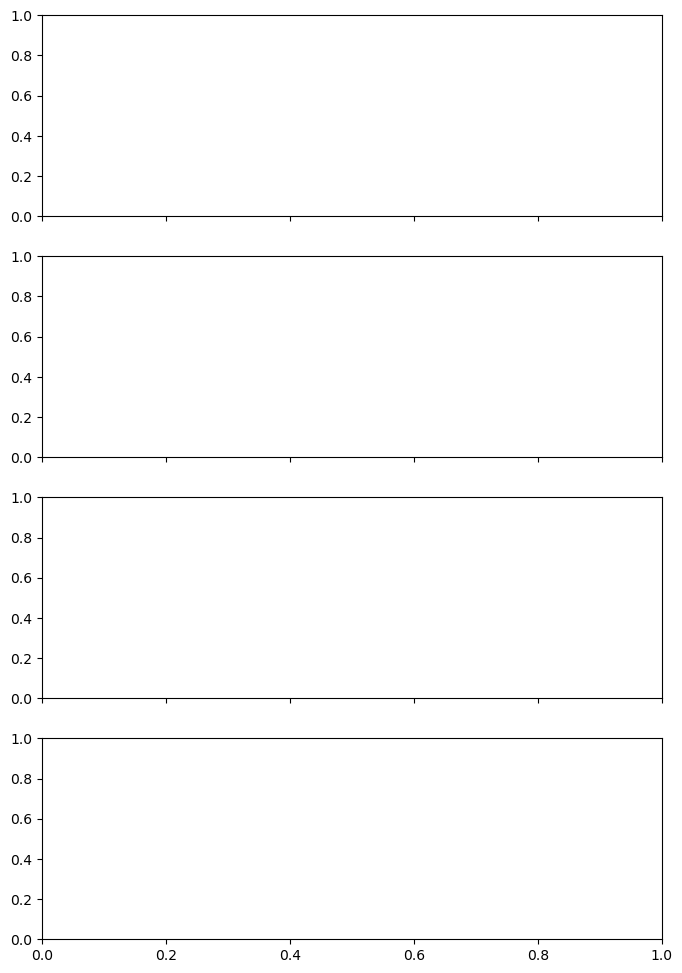

In [38]:
wind=2;
output_pdf_file = r'C:\Users\bvarugu\Documents\compare_overlap_area_InSAR_ts.pdf';
# # Get date list
date_list1 = timeseries(InSAR_ts_filename1).get_date_list()
date_list2 = timeseries(InSAR_ts_filename2).get_date_list()
insar_dates1 = ptime.date_list2vector(date_list1)[0];
insar_dates2 = ptime.date_list2vector(date_list2)[0];
coord_coverter1 = ut.coordinate(insar_metadata1)#
coord_coverter2 = ut.coordinate(insar_metadata2)
num_site = len(sample_points)
prog_bar = ptime.progressBar(maxValue=num_site)
with PdfPages(output_pdf_file) as pdf:
    fig_count = 0  # To keep track of how many figures are plotted on a page
    fig, axs = plt.subplots(4, 1, figsize=(8, 12), sharex=True)  # Create a 4x1 grid of subplots (4 figures per page)
    for i in range(len(sample_points)):
        prog_bar.update(i+1, suffix=f'{i+1}/{num_site}');
    
        # read InSAR
        y1, x1 = coord_coverter1.geo2radar(sample_points_lats[i], sample_points_lons[i])[0:2];
        y2, x2 = coord_coverter2.geo2radar(sample_points_lats[i], sample_points_lons[i])[0:2];
        #insar_dis = insar_ts[:, y, x] - ref_insar_dis;
        insar_ts1_dis = np.nanmean(insar_ts1[:, y1-wind:y1+wind, x1-wind:x1+wind],axis=(1,2)) #- ref_insar_dis;
        insar_ts2_dis = np.nanmean(insar_ts2[:, y2-wind:y2+wind, x2-wind:x2+wind],axis=(1,2)) 
        
        if mask1[y1,x1] !=0 and mask2[y2,x2] !=0:
            ax = axs[fig_count % 4]  # Access the current subplot in the 4x1 grid
            #save_fig_name = os.path.join(gps_plot_dir,'GNSS_{}_vs_INSAR_LOS.png'.format(site_name));
            ax.scatter(insar_dates1, insar_ts1_dis*1000, label="TS1+GNSS", s=25, color='red',alpha=0.5);
            ax.scatter(insar_dates2, insar_ts2_dis*1000, label="TS2+GNSS", s=25, color='orange',alpha=0.5);
            #ax.scatter(insar_dates, ifg_gnss_dis*1000, label="IFG+GNSS", s=25, color='orange',alpha=0.5);
            #ax.scatter(insar_dates, ifg_gnss_corr_dis*1000, label="IFG+GNSS+Corr", s=25, color='red',alpha=0.5);
            # axis format
            ax.set_title(f"Point: {i+1},{sample_points_lats[i]},{sample_points_lons[i]}") 
            ax.set_ylabel('LOS displacement [mm]');
            ylim = int(np.ceil((max(abs(insar_ts1_dis))*1000)/100))*100;
            ax.set_ylim([-ylim,ylim]);
            ax.legend();
             # Slant x-axis labels to 45 degrees
            #plt.setp(ax.get_xticklabels(), rotation=45, ha="right")  
            fig_count += 1

            # Save to PDF every 4 plots and reset figure
            if fig_count % 4 == 0:
                pdf.savefig(fig)  # Save current page to PDF
                plt.close(fig)    # Close the figure to free memory
                fig_count = 0
                fig, axs = plt.subplots(4, 1, figsize=(8, 12), sharex=True)  # Create new 4x1 figure for next 4 plots
    if fig_count > 0:
        pdf.savefig(fig)
        plt.close(fig)
prog_bar.close()